In [1]:
import velvet as vt

# general packages
import numpy as np
import pandas as pd
import torch
from scipy.sparse import issparse

# velocity packages
import scanpy as sc
import scvelo as scv
import anndata as ann

# plotting packages
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm, trange
from IPython.display import clear_output

# color palette object
from colors import colorpalette as colpal

Global seed set to 0
/camp/home/maizelr/.local/lib/python3.10/site-packages/pytorch_lightning/utilities/warnings.py:53: LightningDeprecationWarning: pytorch_lightning.utilities.warnings.rank_zero_deprecation has been deprecated in v1.6 and will be removed in v1.8. Use the equivalent function from the pytorch_lightning.utilities.rank_zero module instead.
  new_rank_zero_deprecation(
/camp/home/maizelr/.local/lib/python3.10/site-packages/pytorch_lightning/utilities/warnings.py:58: LightningDeprecationWarning: The `pytorch_lightning.loggers.base.rank_zero_experiment` is deprecated in v1.7 and will be removed in v1.9. Please use `pytorch_lightning.loggers.logger.rank_zero_experiment` instead.
  return new_rank_zero_deprecation(*args, **kwargs)


In [2]:
from anndata._core.anndata import AnnData
from matplotlib import patches

In [3]:
nmp = sc.read_h5ad('../data/nmp_data_1606.h5ad')

state_path = '../models/nmp_vf_1606_model.pt'

vt.md.Velvet.setup_anndata(nmp, x_layer='total', n_layer='new', knn_layer='knn_index')

model = vt.md.Velvet(
    nmp,
    n_latent = 50,
    linear_decoder = True,
    neighborhood_space="latent_space",
    biophysical_model = "full",
    gamma_mode = "learned",
    labelling_time = 2.0,
)

model.setup_model()

trained_state = torch.load(state_path)['model_state_dict']

model.module.load_state_dict(trained_state)

INFO     Generating sequential column names                                                                        


<All keys matched successfully>

In [4]:
model.module = model.module.to('cuda')

model.adata.obs['index'] = np.arange(model.adata.shape[0])

vt.sm.VelvetSDE.setup_anndata(
    model, 
    x_layer='total', 
    index_key='index'
)

markov = vt.sb.MarkovProcess(
    model,
    n_neighbors=10,
    use_space='latent_space',
    use_spline=True, 
    use_similarity=False
)

sde = vt.sb.SDE(
    model.module.n_latent,
    prior_vectorfield=model.module.vf,
    noise_scalar=0.1,
    device=model.device
)

sde_model = vt.sm.VelvetSDE(
    model,
    sde,
    markov,
)


sde_state_path = '../models/nmp_sde_1606_model.pt'

trained_state_sde = torch.load(sde_state_path)['model_state_dict']

sde_model.module.load_state_dict(trained_state_sde)

KNN indices for Velvet stored in .obsm['knn_index'].


<All keys matched successfully>

In [5]:
def bifurcation_probability(
    initial_cells,
    cell_ids,
    cluster_labels
):
    n_cells = initial_cells.shape[0]
    all_cell_ids = np.arange(n_cells)
    
    cell_ids = np.array(cell_ids)
    cluster_labels = np.array(cluster_labels)
    
    fates = np.unique(cluster_labels)
    cells = np.unique(cell_ids)
    data_dict = {fate:np.zeros(n_cells) for fate in fates}
    
    for i in range(n_cells):
        if i in cells:
            cell_fates = cluster_labels[cell_ids==i]
            for fate in fates:
                data_dict[fate][i] = np.mean(cell_fates==fate)
        else:
            for fate in fates:
                data_dict[fate][i] = 0
            
    
    for fate in fates:
        initial_cells.obs[f"fate_prob_{fate}"] = data_dict[fate]
        
    return initial_cells

In [6]:
init_cells = {}
sim_results = {}
cluster_results = {}

for tp in sde_model.adata.obs.timepoint.unique():
    print(f"Simulating {tp}")
    inits = sde_model.adata[sde_model.adata.obs.timepoint==tp]
    trajectories, cell_ids = sde_model.simulate(
        initial_cells=inits,
        n_samples_per_cell=10,
        n_steps = 100,
        t_max = 70,
        dt = 1.0,
        latent_key='X_z',
        n_chunks=10
    )

    sim_results[tp] = (trajectories, cell_ids)
    
    print(f"Clustering {tp}")    
    avg_center, labels, centers, index = vt.cl.cluster_trajectories(trajectories, n_clusters=2)
    cluster_labels = labels.cpu().numpy()
    cluster_results[tp] = (labels, cluster_labels)

    print(f"Processing {tp}")
    init_cells[tp] = bifurcation_probability(
        inits,
        cell_ids,
        cluster_labels
    )

Simulating D4


Simulating Chunk 9: 100%|██████████| 10/10 [00:01<00:00,  8.69it/s]


Clustering D4
Processing D4
Simulating D5


Simulating Chunk 9: 100%|██████████| 10/10 [00:00<00:00, 16.97it/s]


Clustering D5
Processing D5
Simulating D3.2


Simulating Chunk 9: 100%|██████████| 10/10 [00:00<00:00, 15.12it/s]


Clustering D3.2
Processing D3.2
Simulating D3.4


Simulating Chunk 9: 100%|██████████| 10/10 [00:00<00:00, 14.78it/s]


Clustering D3.4
Processing D3.4
Simulating D3.6


Simulating Chunk 9: 100%|██████████| 10/10 [00:00<00:00, 13.81it/s]


Clustering D3.6
Processing D3.6
Simulating D3.8


Simulating Chunk 9: 100%|██████████| 10/10 [00:00<00:00, 14.65it/s]


Clustering D3.8
Processing D3.8


In [7]:
for tp in sde_model.adata.obs.timepoint.unique():
    init_cells[tp].write_h5ad(f'../data/NMP_{tp}_init_cells_1606.h5ad')
    torch.save(sim_results[tp][0], f'../data/NMP_{tp}_trajectories_1606.pt')
    torch.save(sim_results[tp][1], f'../data/NMP_{tp}_cellids_1606.pt')
    torch.save(cluster_results[tp][0], f'../data/NMP_{tp}_labels_1606.pt')
    np.save(f'../data/NMP_{tp}_labels_1606.npy', cluster_results[tp][1])

# Analysis

In [6]:
init_cells = {}
sim_results = {}
cluster_results = {}
for tp in tqdm(sde_model.adata.obs.timepoint.unique()):
    init_cells[tp] = sc.read_h5ad(f'../data/NMP_{tp}_init_cells_1606.h5ad')
    sim_results[tp] = (
        torch.load(f'../data/NMP_{tp}_trajectories_1606.pt'),
        torch.load(f'../data/NMP_{tp}_cellids_1606.pt')
    )
    cluster_results[tp] = (
        torch.load(f'../data/NMP_{tp}_labels_1606.pt'),
        np.load(f'../data/NMP_{tp}_labels_1606.npy')
    )


100%|██████████| 6/6 [00:14<00:00,  2.50s/it]


In [7]:
def viz(model, trajectories, cluster_labels, components=[0,1], cmap = {1:'gold',0:'limegreen'}):
    z = model.adata.obsm['X_z']
    z = torch.tensor(z, device=model.device)

    pca = PCA()
    z_pca = pca.fit_transform(z.detach().cpu().numpy())

    t_pca = []
    for traj in trajectories:
        t_pca.append(pca.transform(traj.detach().cpu().numpy()))

    copy = model.adata.copy()
    copy.obsm['X_vae'] = z_pca
    copy.uns["velocity_params"] = {'embeddings':'vae'}
    fig = plt.figure(figsize=(15,8))
    ax1, ax2 = fig.subplots(1,2)

    scv.pl.scatter(copy, basis='vae', color='cell_annotation', alpha=0.1,
                  ax=ax1, size=1000, show=False, components=f"{components[0]+1},{components[1]+1}",
                   legend_loc=False, title="PC1 v. PC2", fontsize=16)
    scv.pl.scatter(copy, basis='vae', color='cell_annotation', alpha=0.1,
                  ax=ax2, size=1000, show=False, components=f"{components[0]+1},{components[1]+2}",
                   legend_loc='right margin', title="PC1 v. PC3", fontsize=16)
    groups = []
    for t, cl in zip(t_pca, cluster_labels):
        color = cmap[cl]
        if cl in groups:
            label=''
        else:
            label=cl
            groups.append(cl)
        ax1.scatter(t[0,components[0]],t[0,components[1]], color='red', marker='x')
        ax2.scatter(t[0,components[0]],t[0,components[1]+1], color='red', marker='x')
        ax1.plot(t[:,components[0]],t[:,components[1]], color=color, alpha=.5, linewidth=2, label=label)
        ax2.plot(t[:,components[0]],t[:,components[1]+1], color=color, alpha=.5, linewidth=2, label=label)
    plt.legend()
    plt.show()

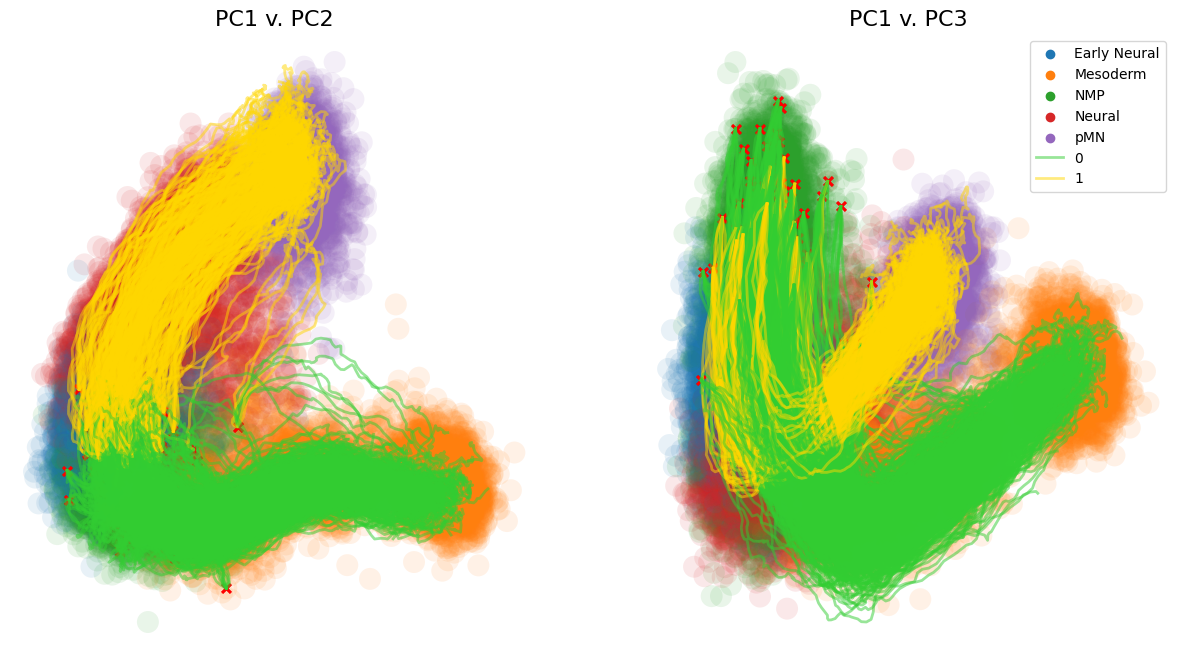

In [8]:
tp = 'D3.2'

trajectories = sim_results[tp][0]
cluster_labels = cluster_results[tp][1]

viz(model, trajectories[:1000], cluster_labels)

In [9]:
cluster_map = {}
cluster_map[tp] = {1:'Neural',0:'Mesoderm'}

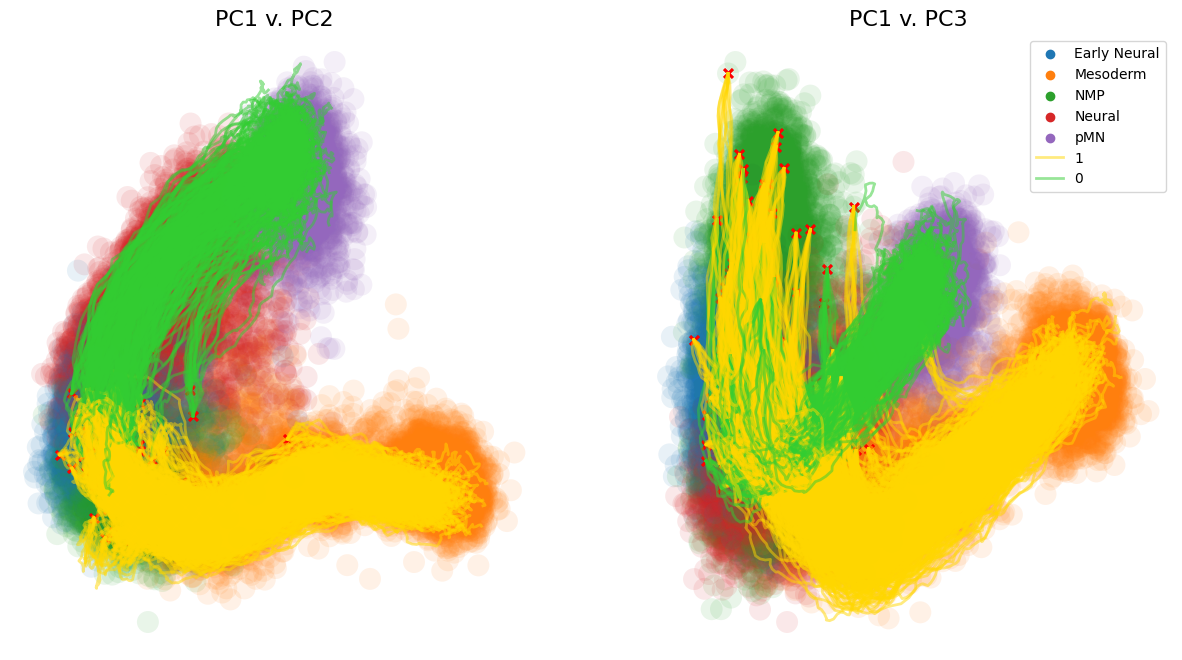

In [10]:
tp = 'D3.4'

trajectories = sim_results[tp][0]
cluster_labels = cluster_results[tp][1]

viz(model, trajectories[:1000], cluster_labels)

In [11]:
cluster_map[tp] = {0:'Neural',1:'Mesoderm'}

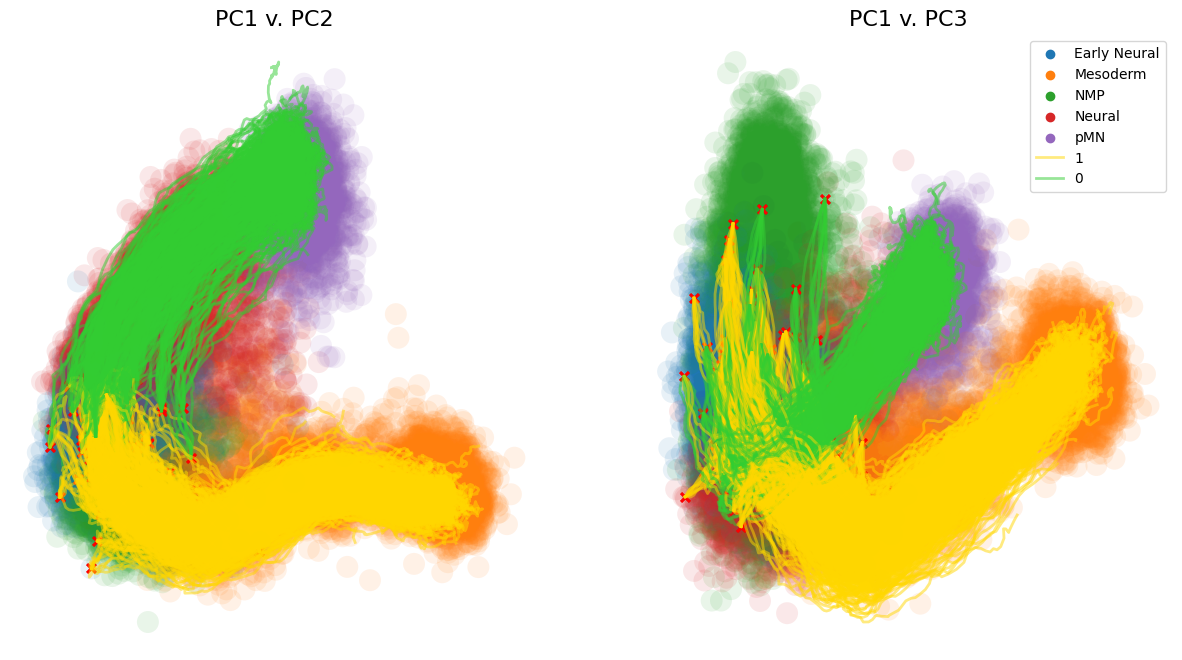

In [12]:
tp = 'D3.6'

trajectories = sim_results[tp][0]
cluster_labels = cluster_results[tp][1]

viz(model, trajectories[:1000], cluster_labels)

In [13]:
cluster_map[tp] = {0:'Neural',1:'Mesoderm'}

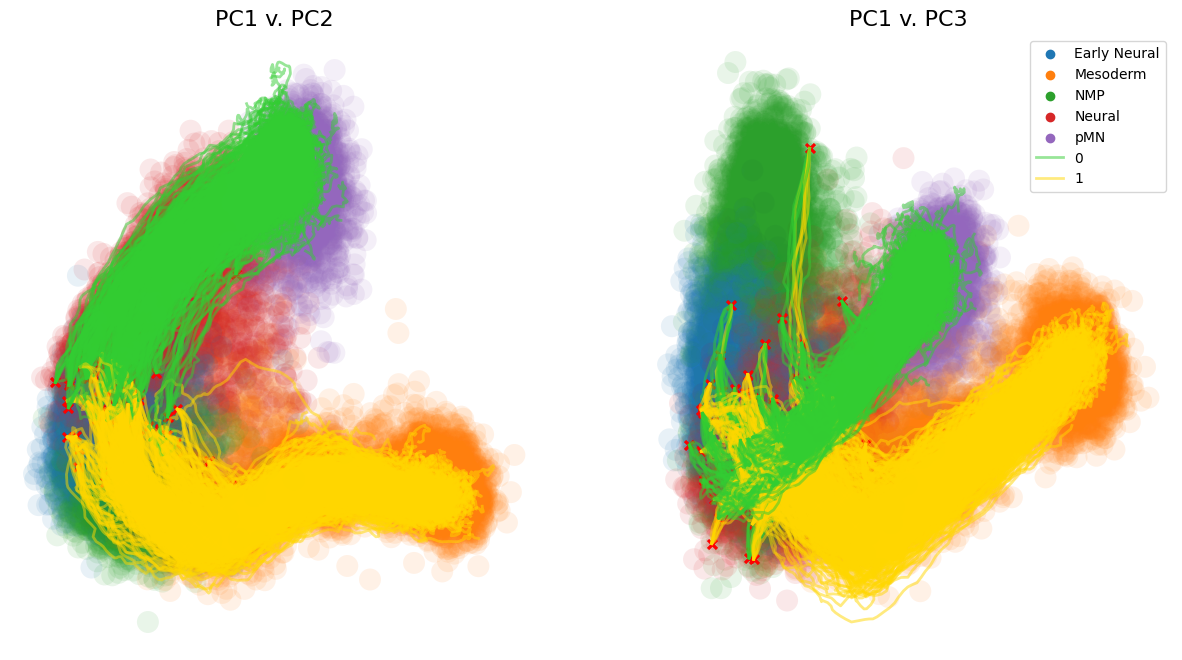

In [14]:
tp = 'D3.8'

trajectories = sim_results[tp][0]
cluster_labels = cluster_results[tp][1]

viz(model, trajectories[:1000], cluster_labels)

In [15]:
cluster_map[tp] = {0:'Neural',1:'Mesoderm'}

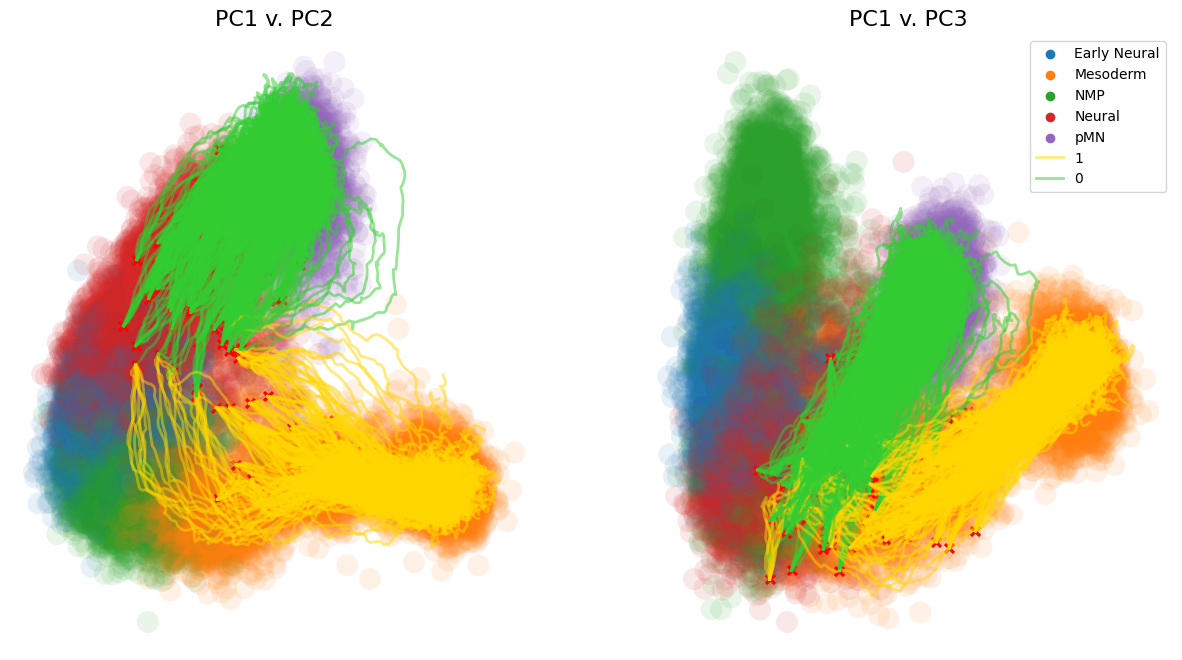

In [16]:
tp = 'D4'

trajectories = sim_results[tp][0]
cluster_labels = cluster_results[tp][1]

viz(model, trajectories[:1000], cluster_labels)

In [17]:
cluster_map[tp] = {0:'Neural',1:'Mesoderm'}

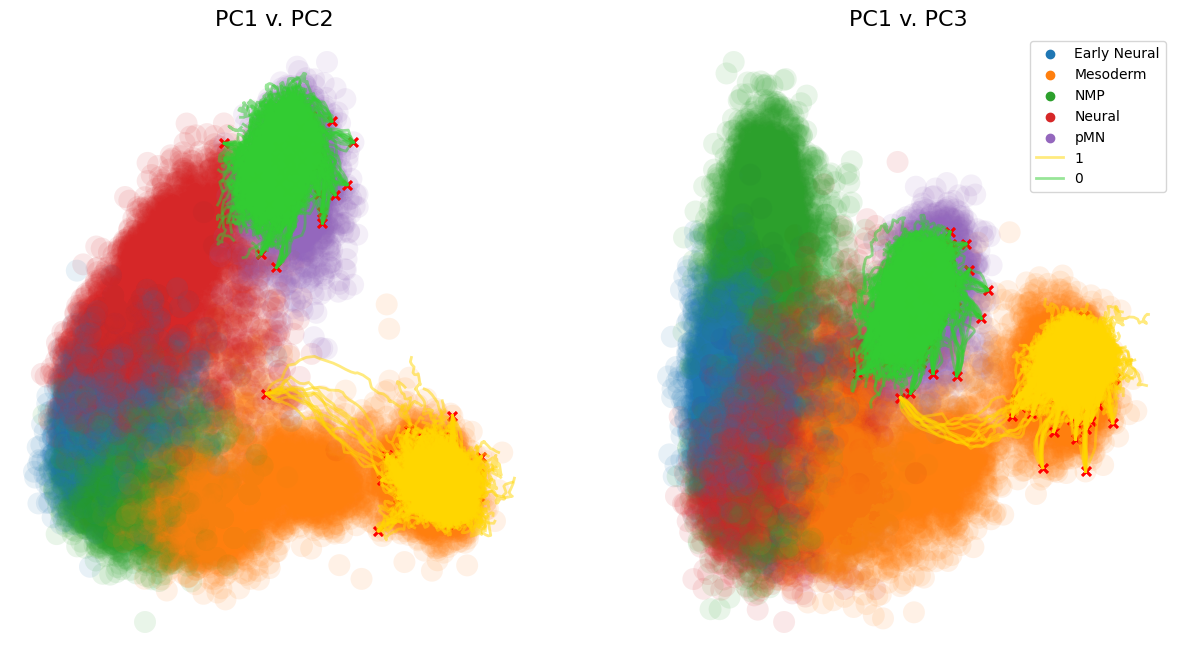

In [18]:
tp = 'D5'

trajectories = sim_results[tp][0]
cluster_labels = cluster_results[tp][1]

viz(model, trajectories[:1000], cluster_labels)

In [19]:
cluster_map[tp] = {0:'Neural',1:'Mesoderm'}

In [23]:
def assign(initial_cells, timepoint, cluster_map):
    fatedesc = []
    for f0, f1 in zip(initial_cells.obs.fate_prob_0.values,initial_cells.obs.fate_prob_1.values):
        if f1==1:
            f = cluster_map[timepoint][f1]
        elif f0==1:
            f = cluster_map[timepoint][f1]
        elif f0==0 and f1==0:
            f = 'off-manifold'
        else:
            f = 'Mixed'
        fatedesc.append(f)
        
    initial_cells.obs['fate_description'] = fatedesc
    
    return initial_cells

from collections import Counter

def plot_string_percentages(arr, palette=None, show_labels=True, save=False):
    counts = Counter(arr)
    percentages = [counts[label] / len(arr) for label in counts]

    labels = list(counts.keys())
    if palette is None:
        colors = None
    else:
        colors = [palette[label] for label in labels]
    plt.figure(dpi=300)
    plt.pie(percentages, colors=colors, autopct='%1.1f%%', 
            textprops={'fontsize': 25, 'color':'white', 'weight':'bold'})

    if not show_labels:
        plt.legend().set_visible(False)
        
    if save:
        for fig in plt.get_fignums():
            fig = plt.figure(fig)
            # Set the figure facecolor to transparent
            fig.patch.set_facecolor('none')

            # Loop over the axes in the figure
            for ax in fig.get_axes():
                # Set the axes facecolor to white
                ax.set_facecolor('white')
                
        plt.savefig(save, bbox_inches='tight')
    
    plt.show()




In [24]:
assigned_cells = {}

for tp in sde_model.adata.obs.timepoint.unique():
    assigned_cells[tp] = assign(init_cells[tp], tp, cluster_map)

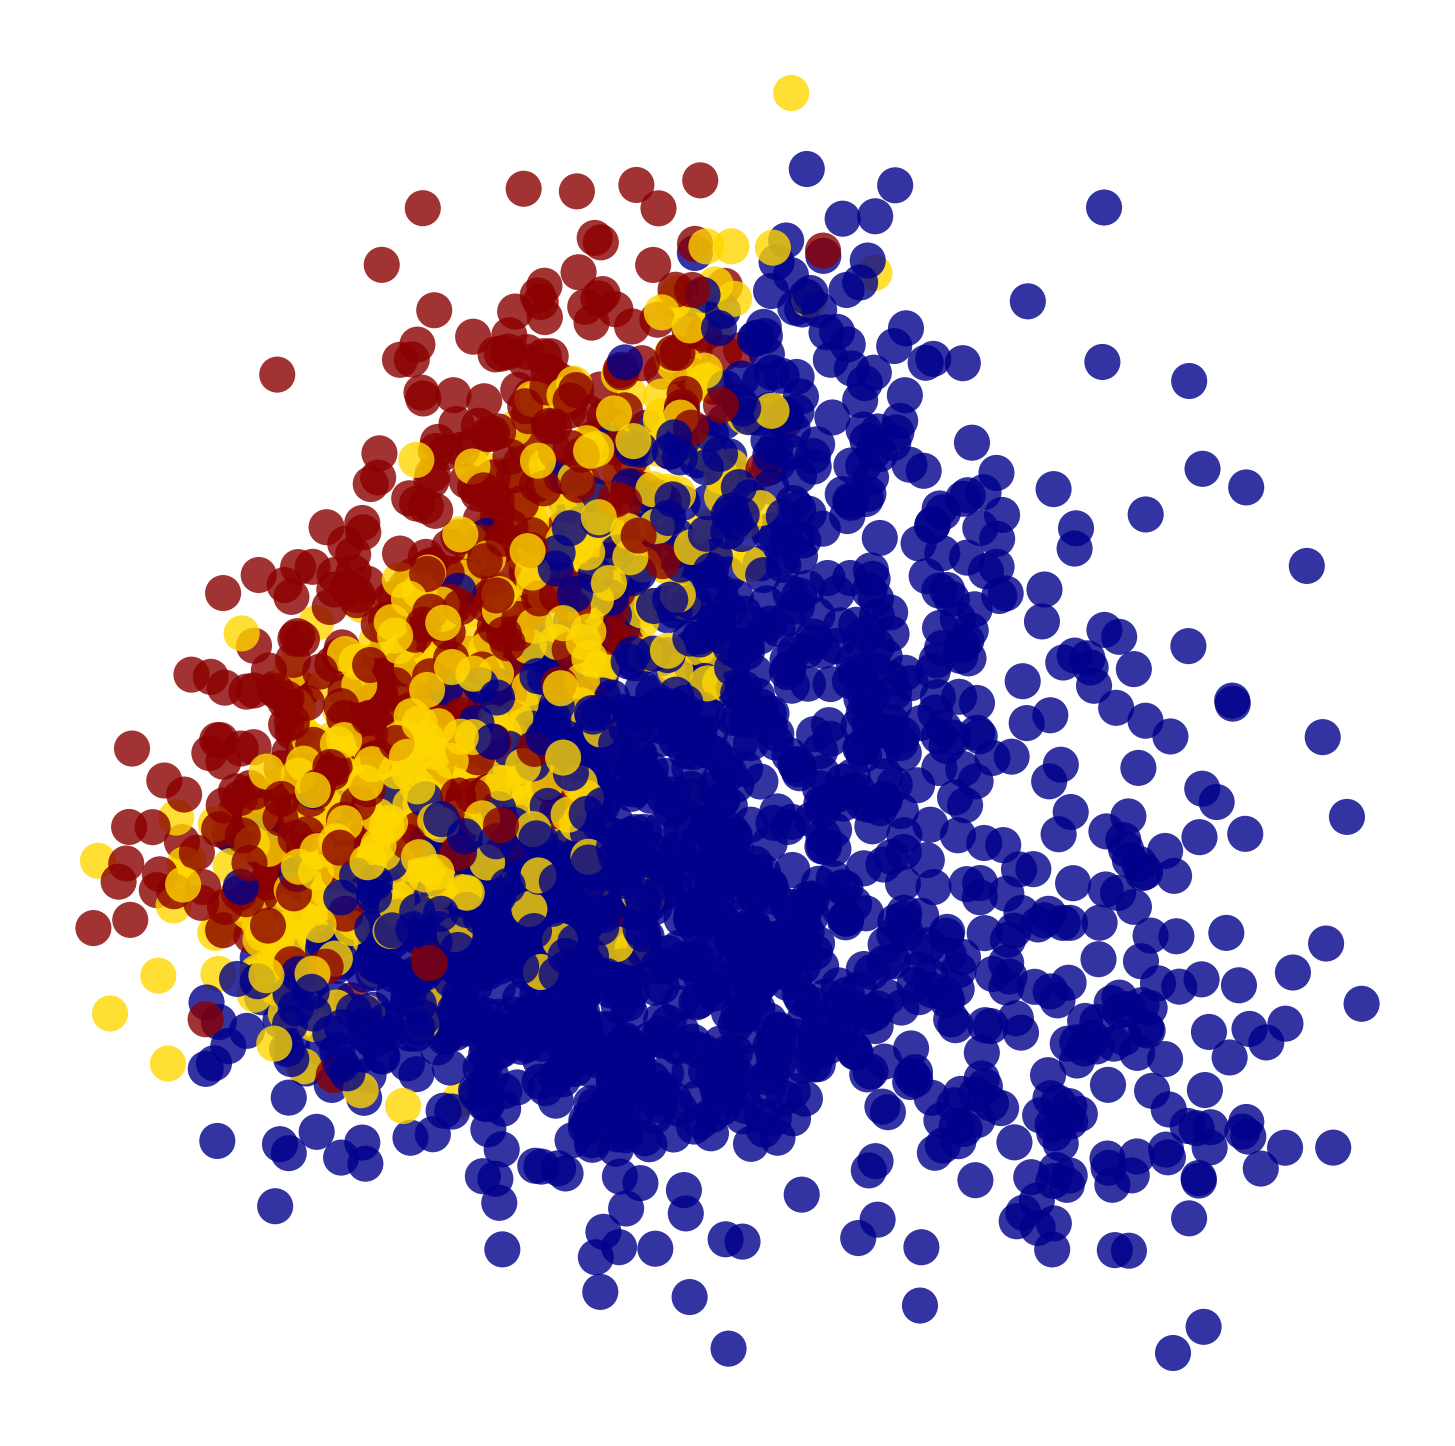

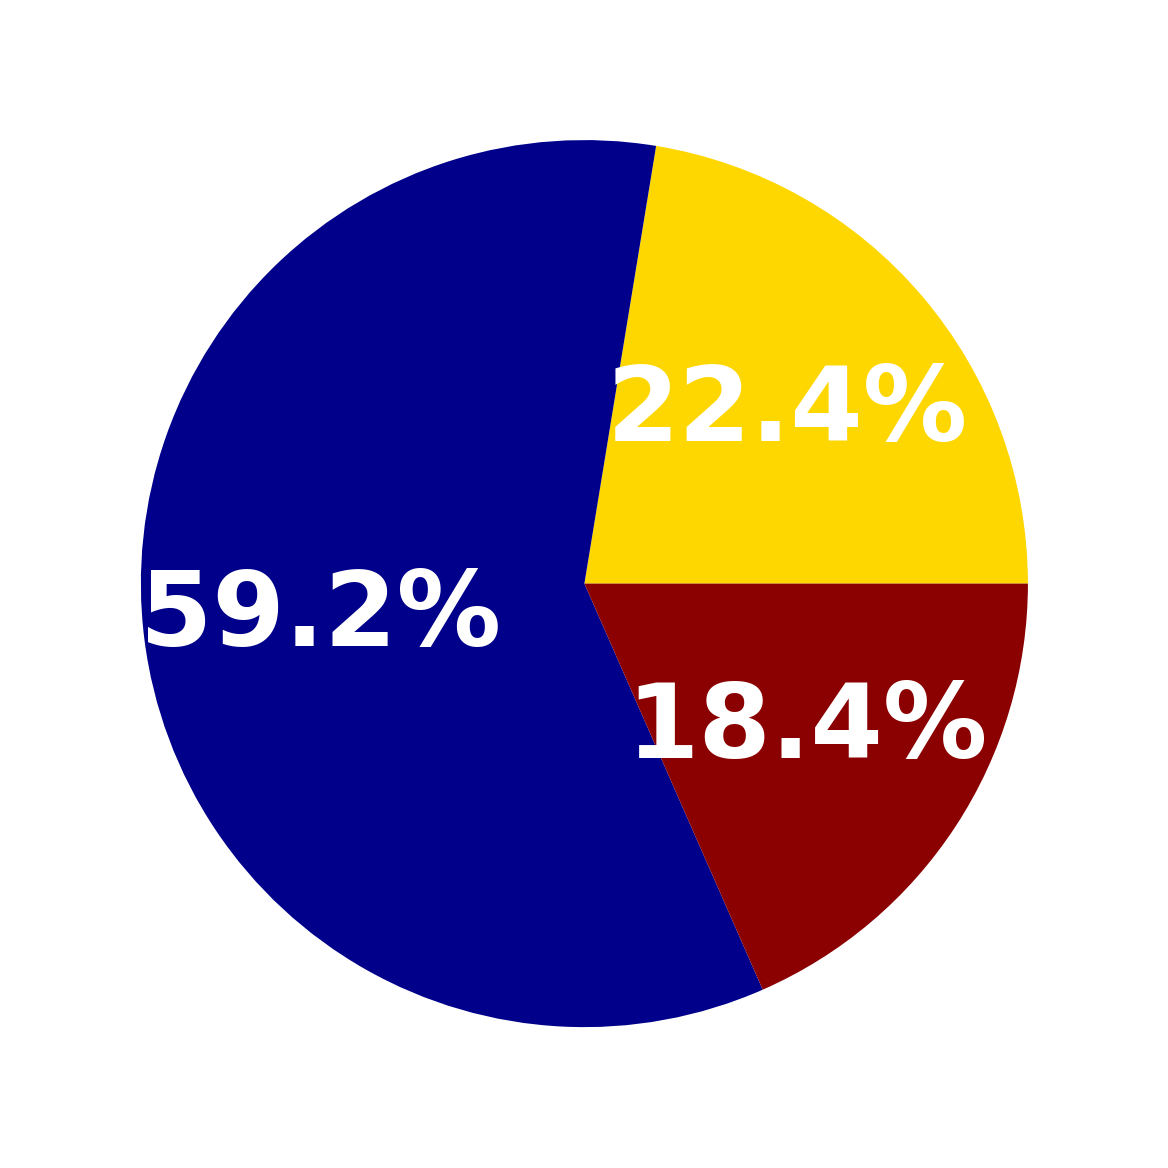

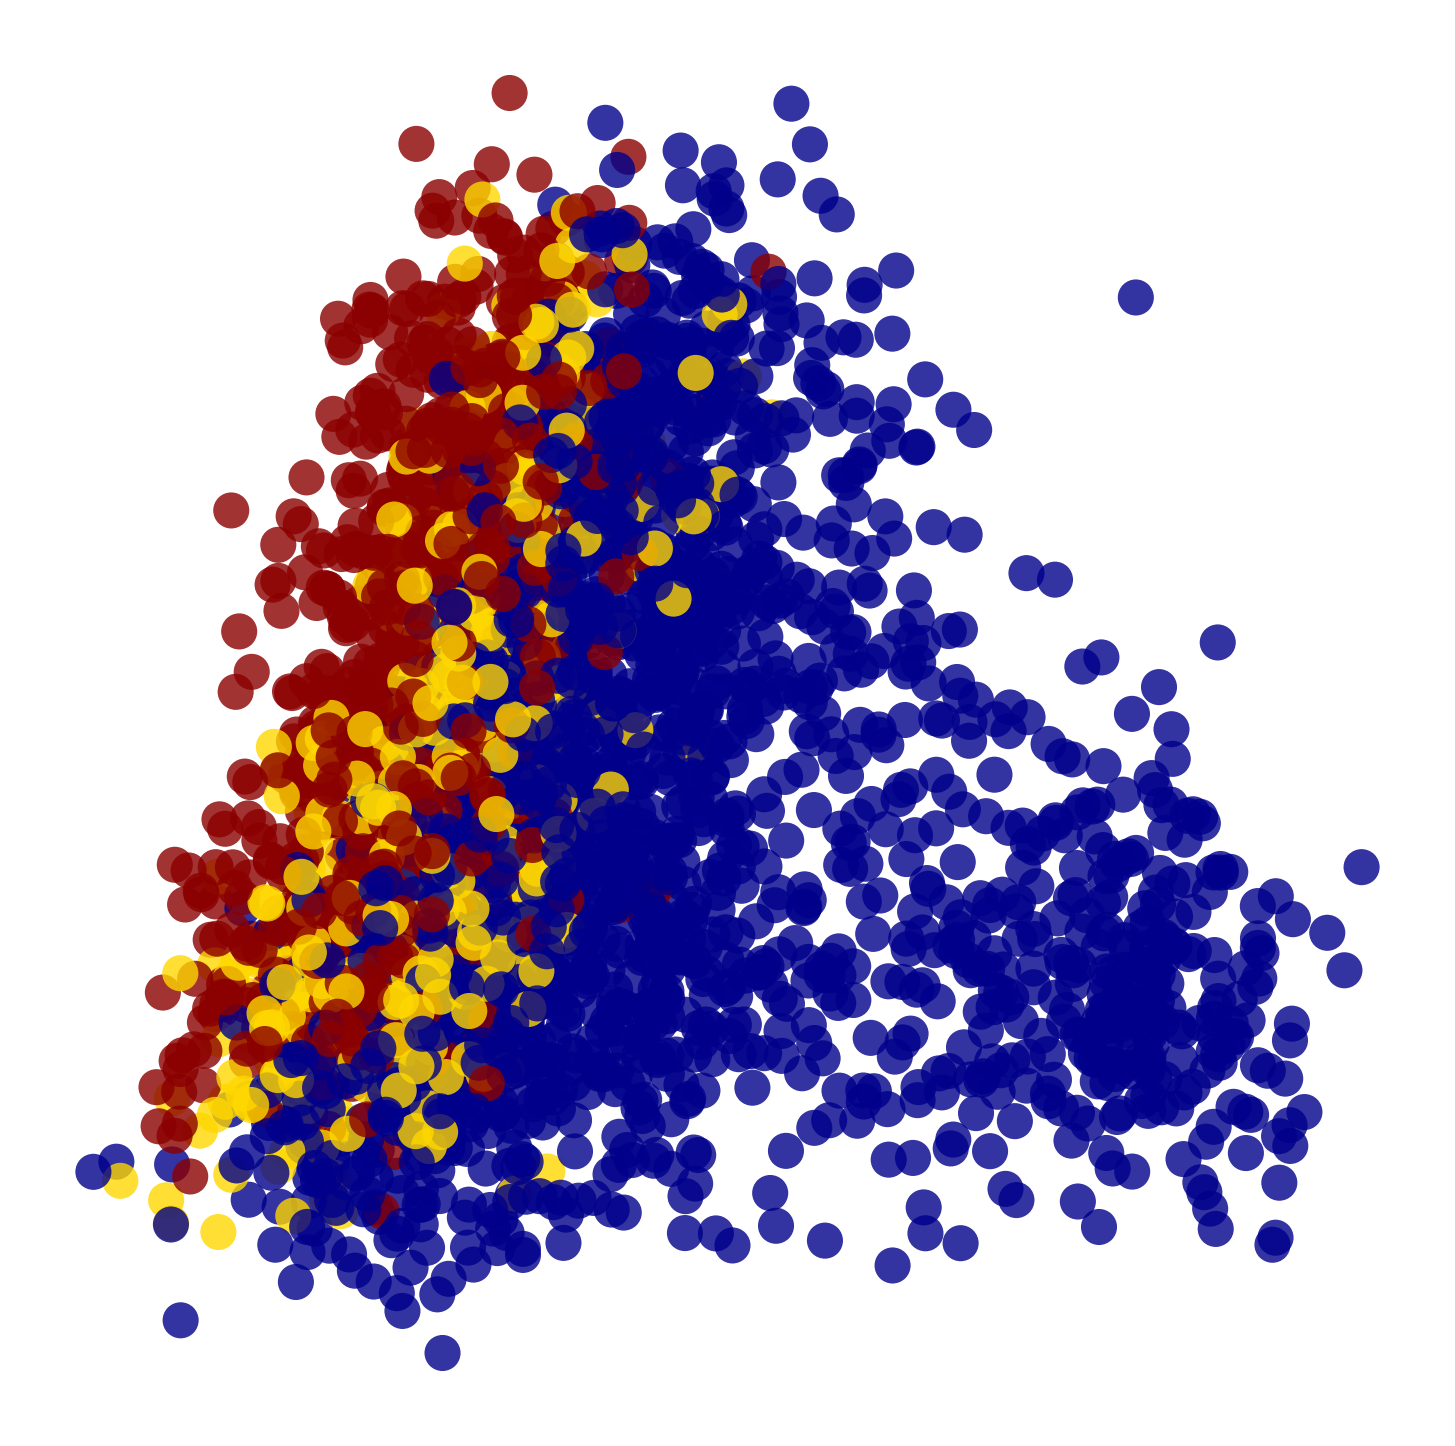

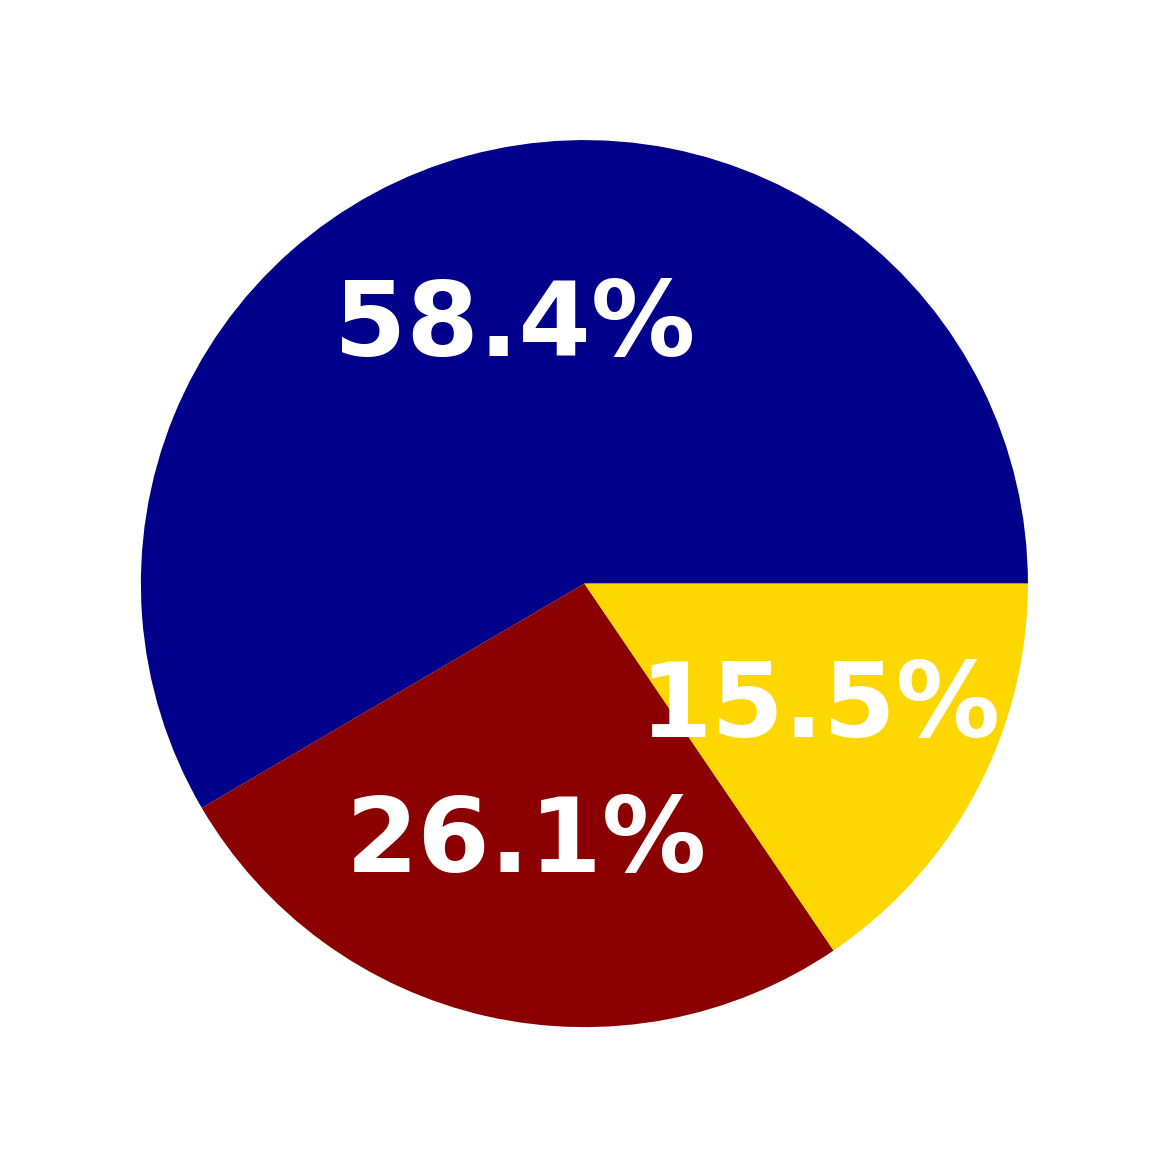

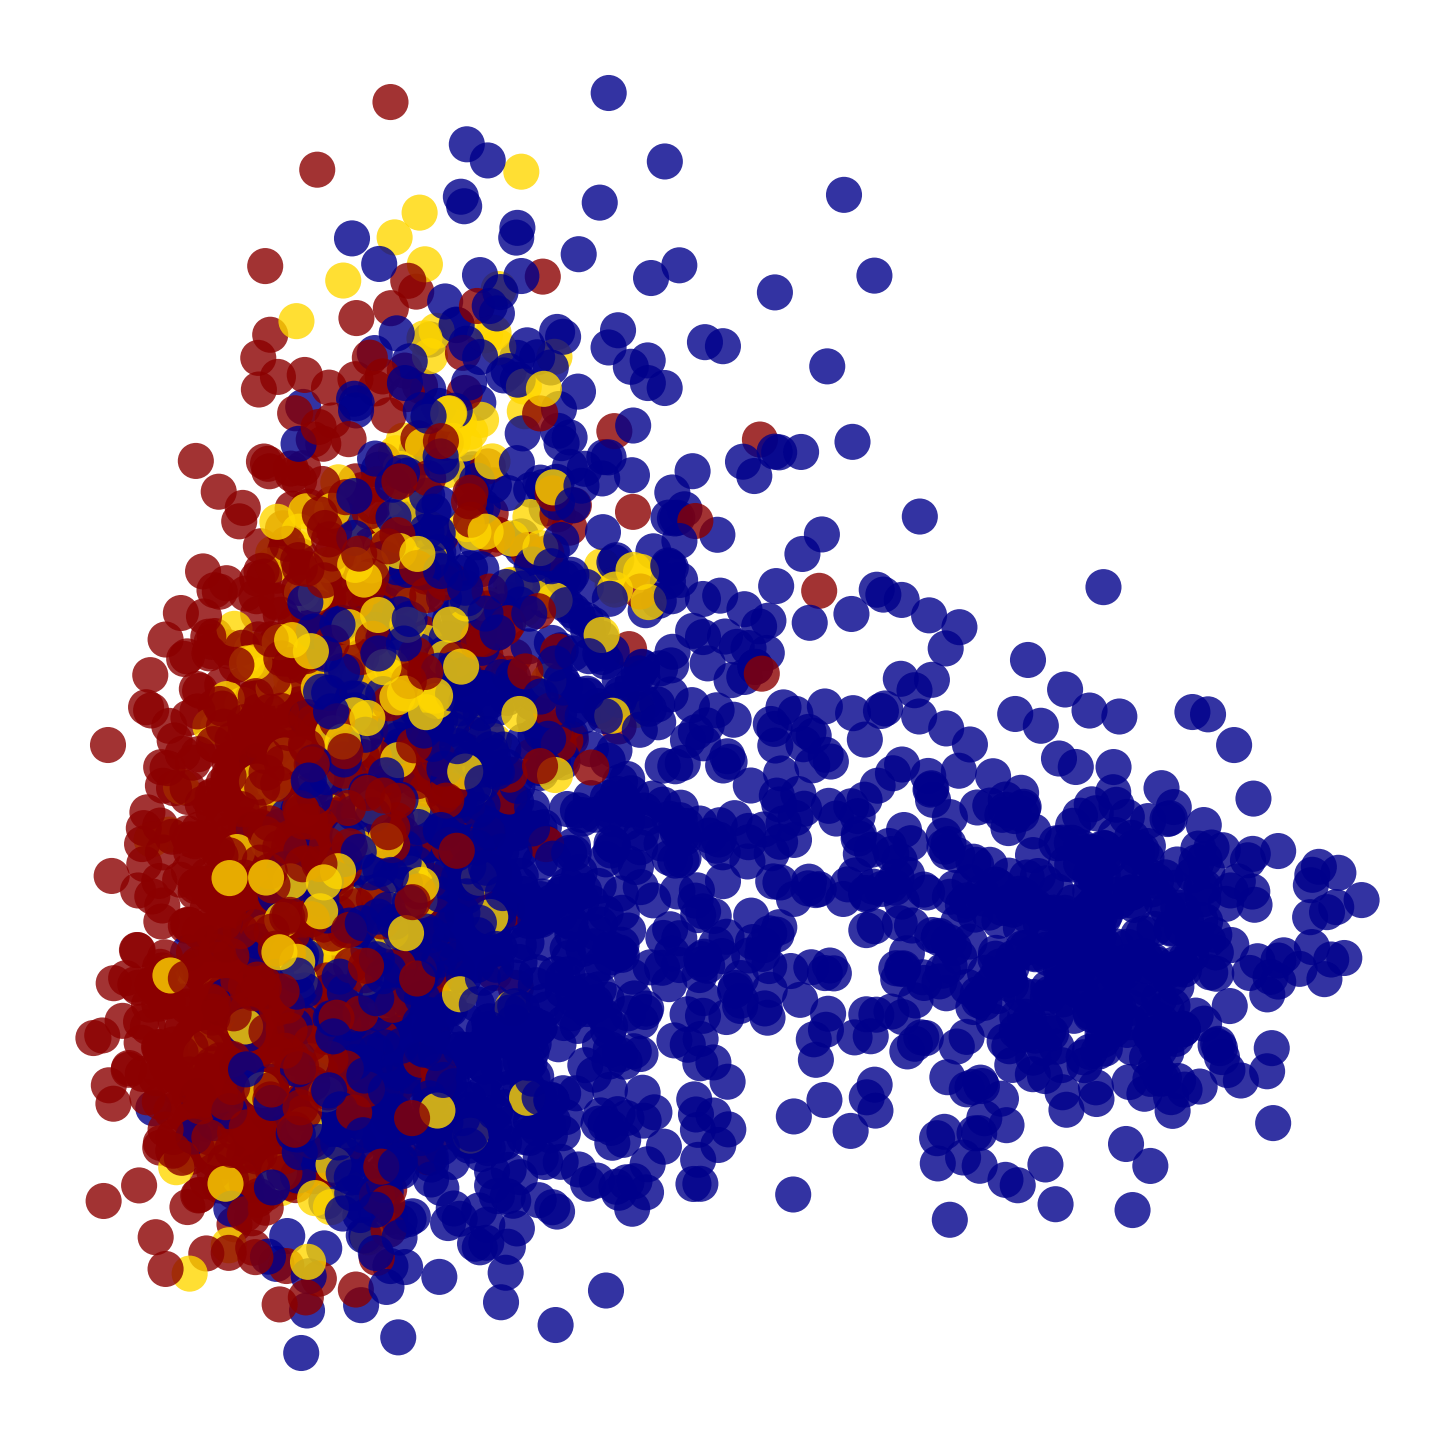

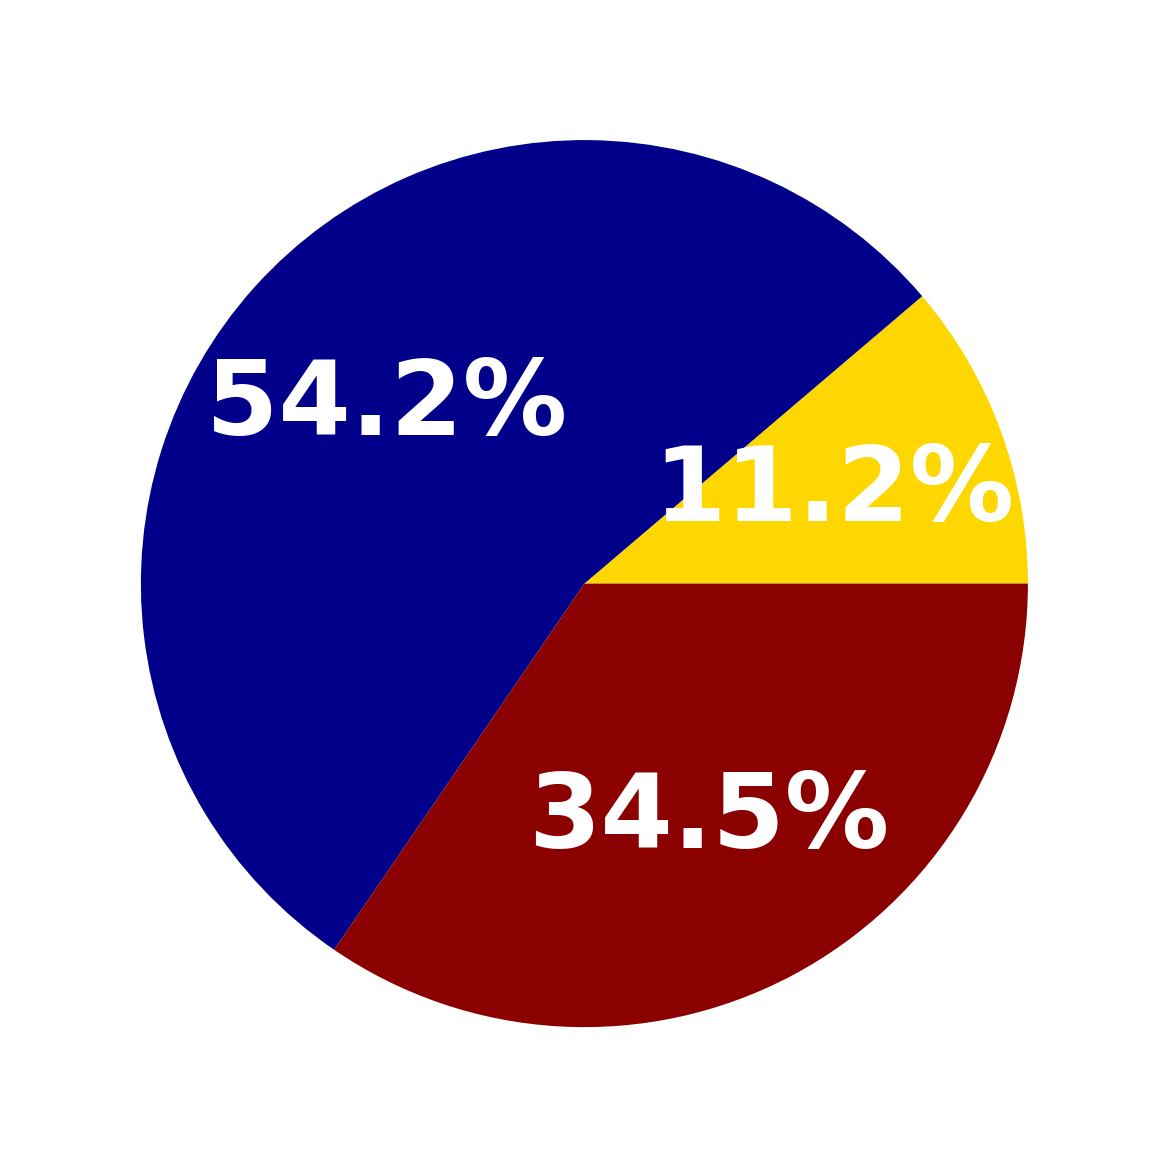

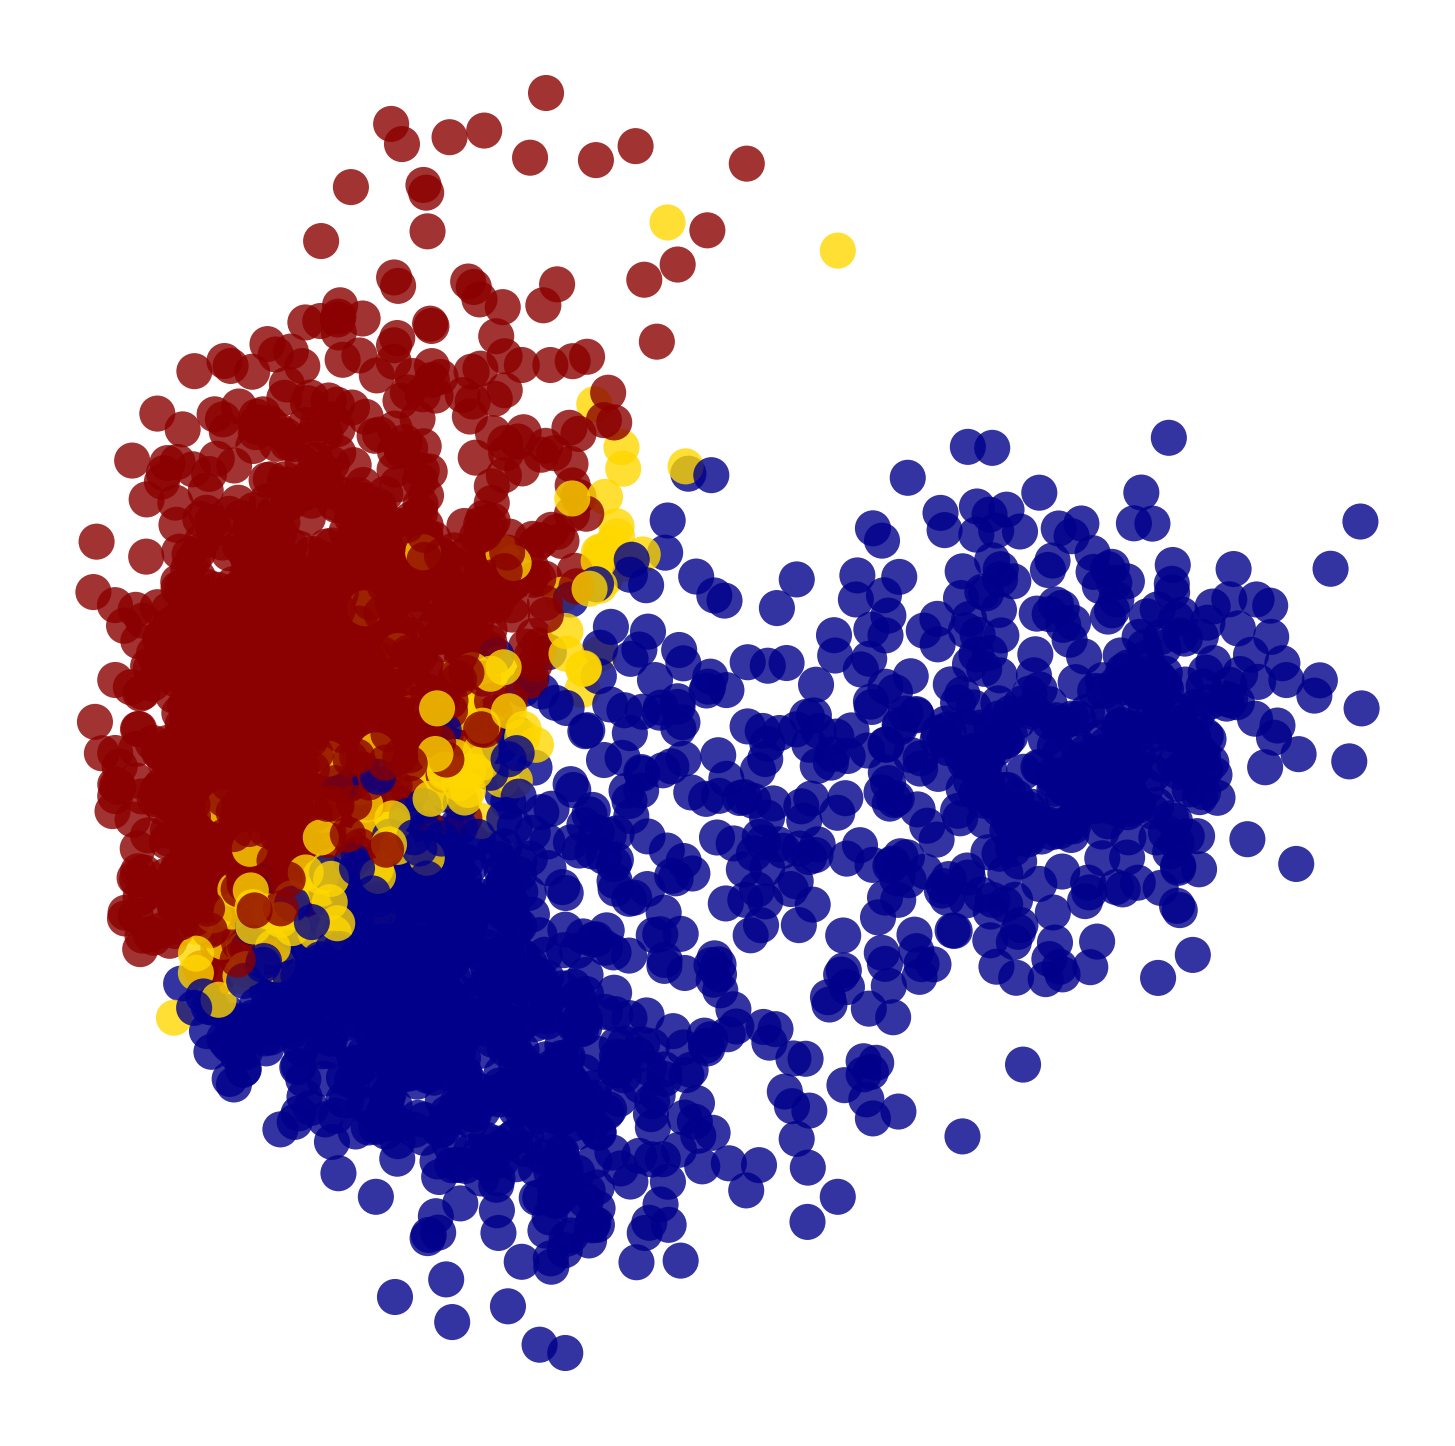

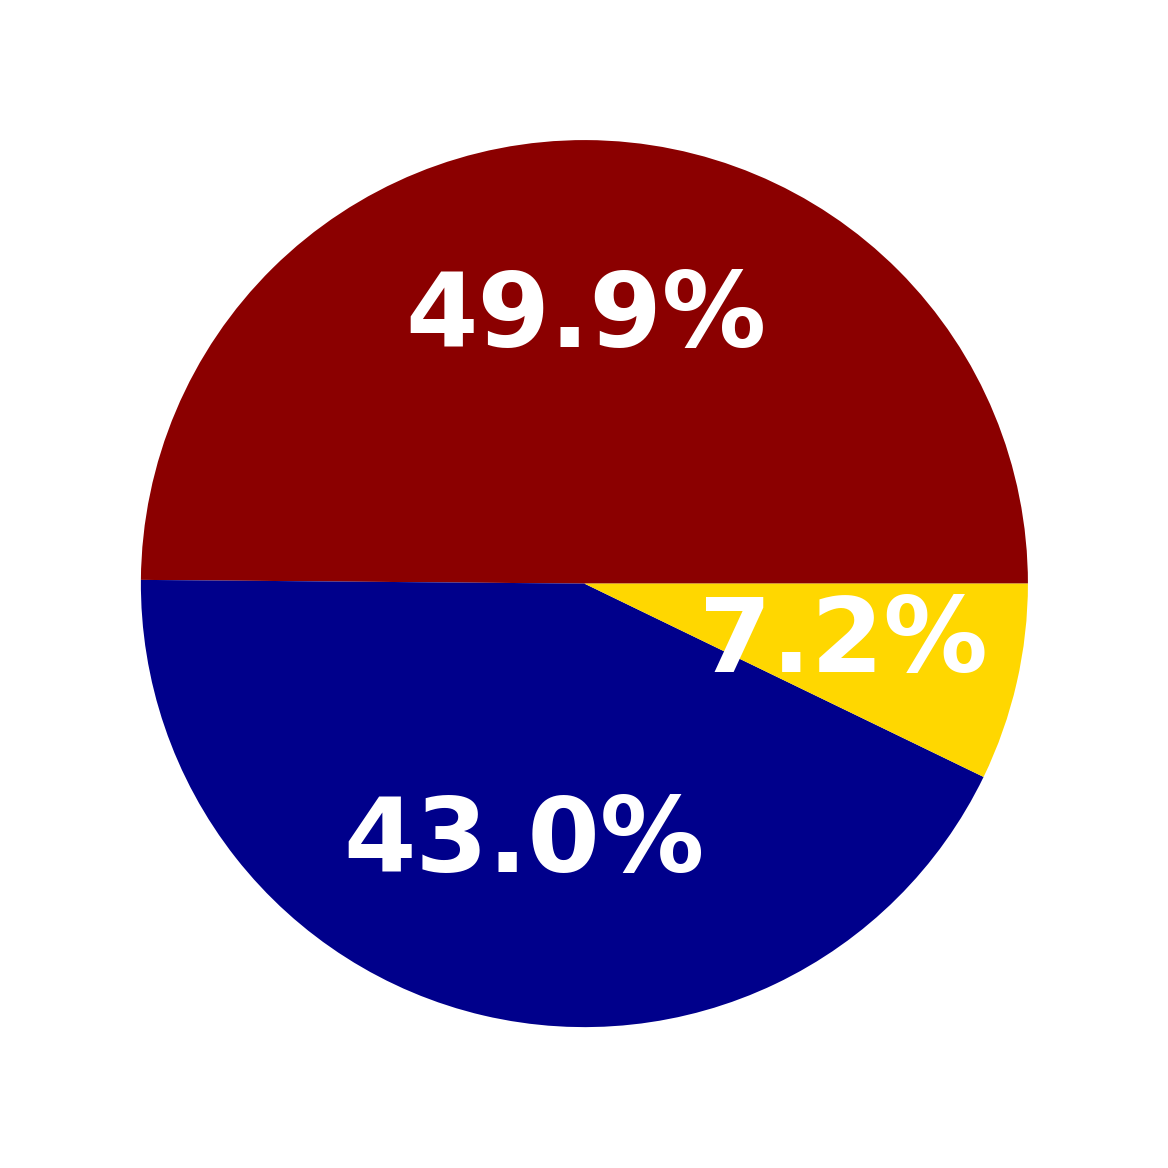

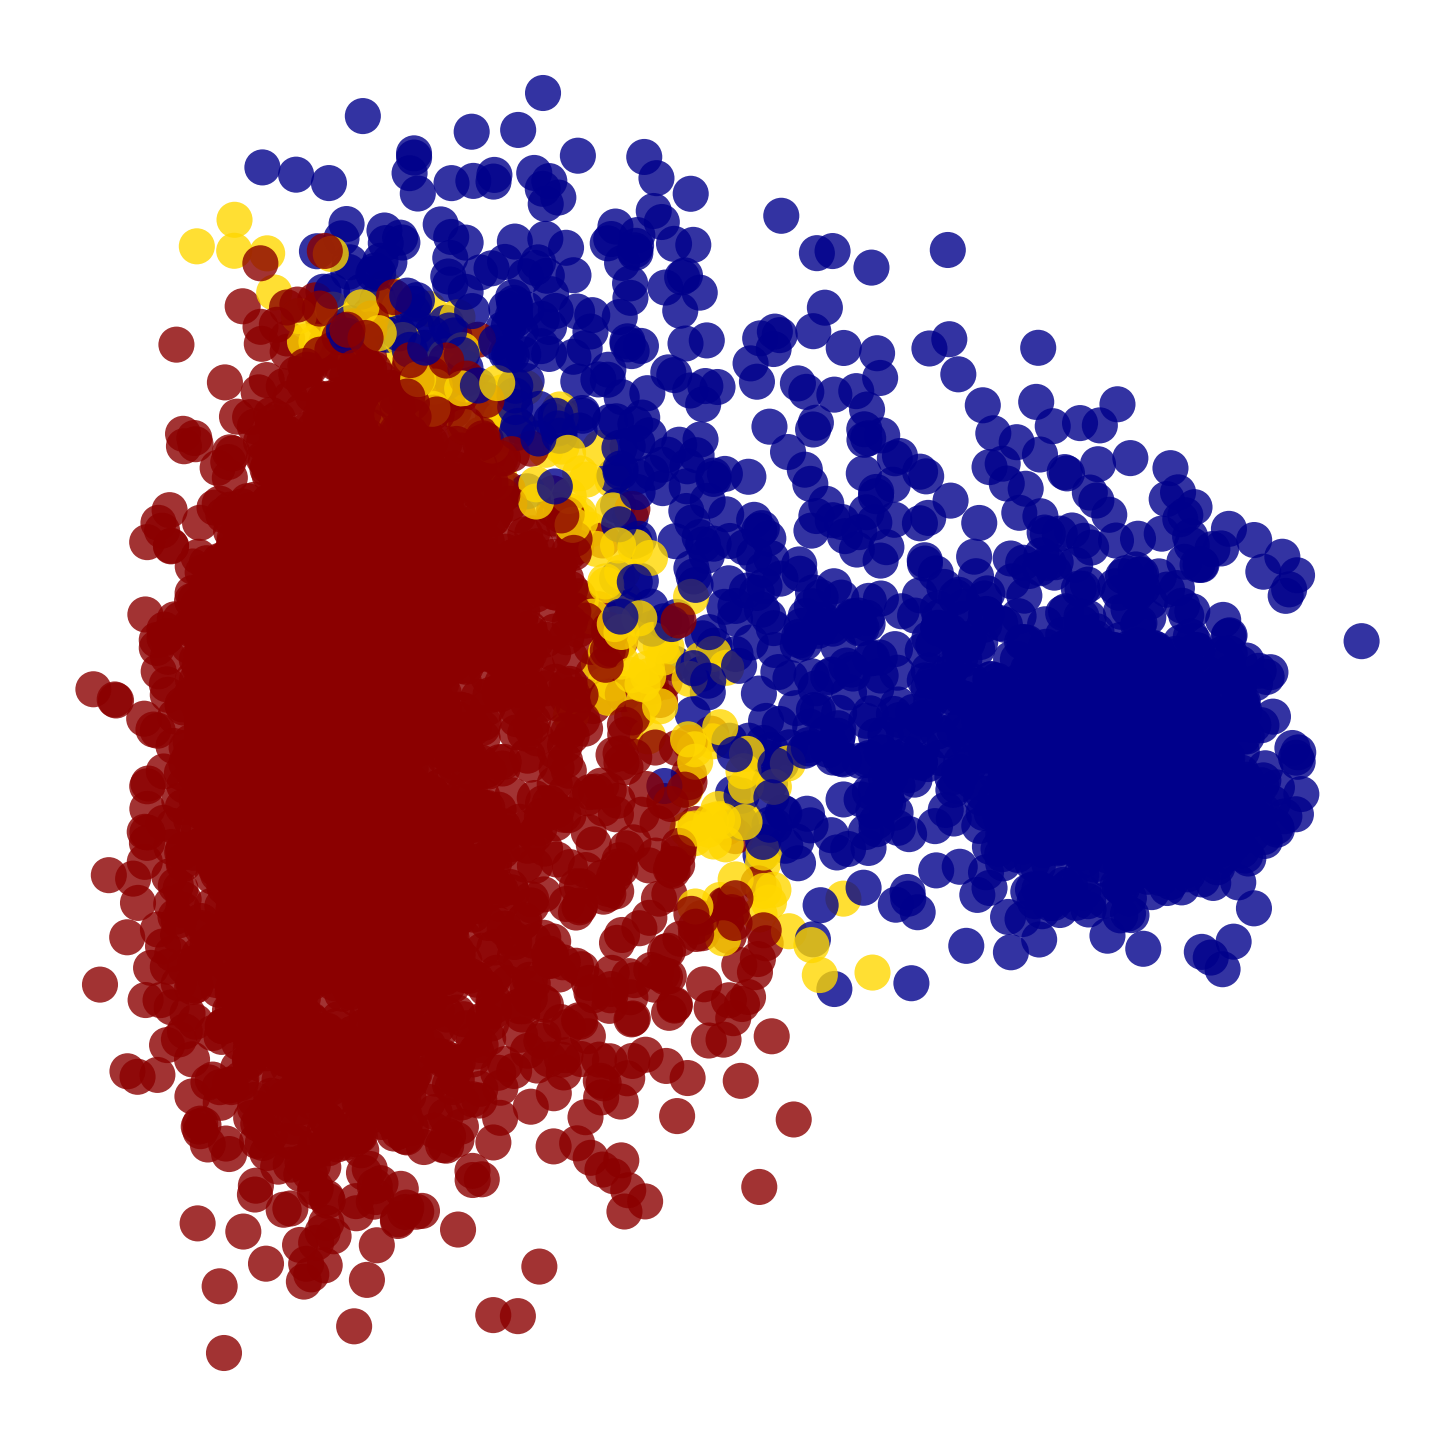

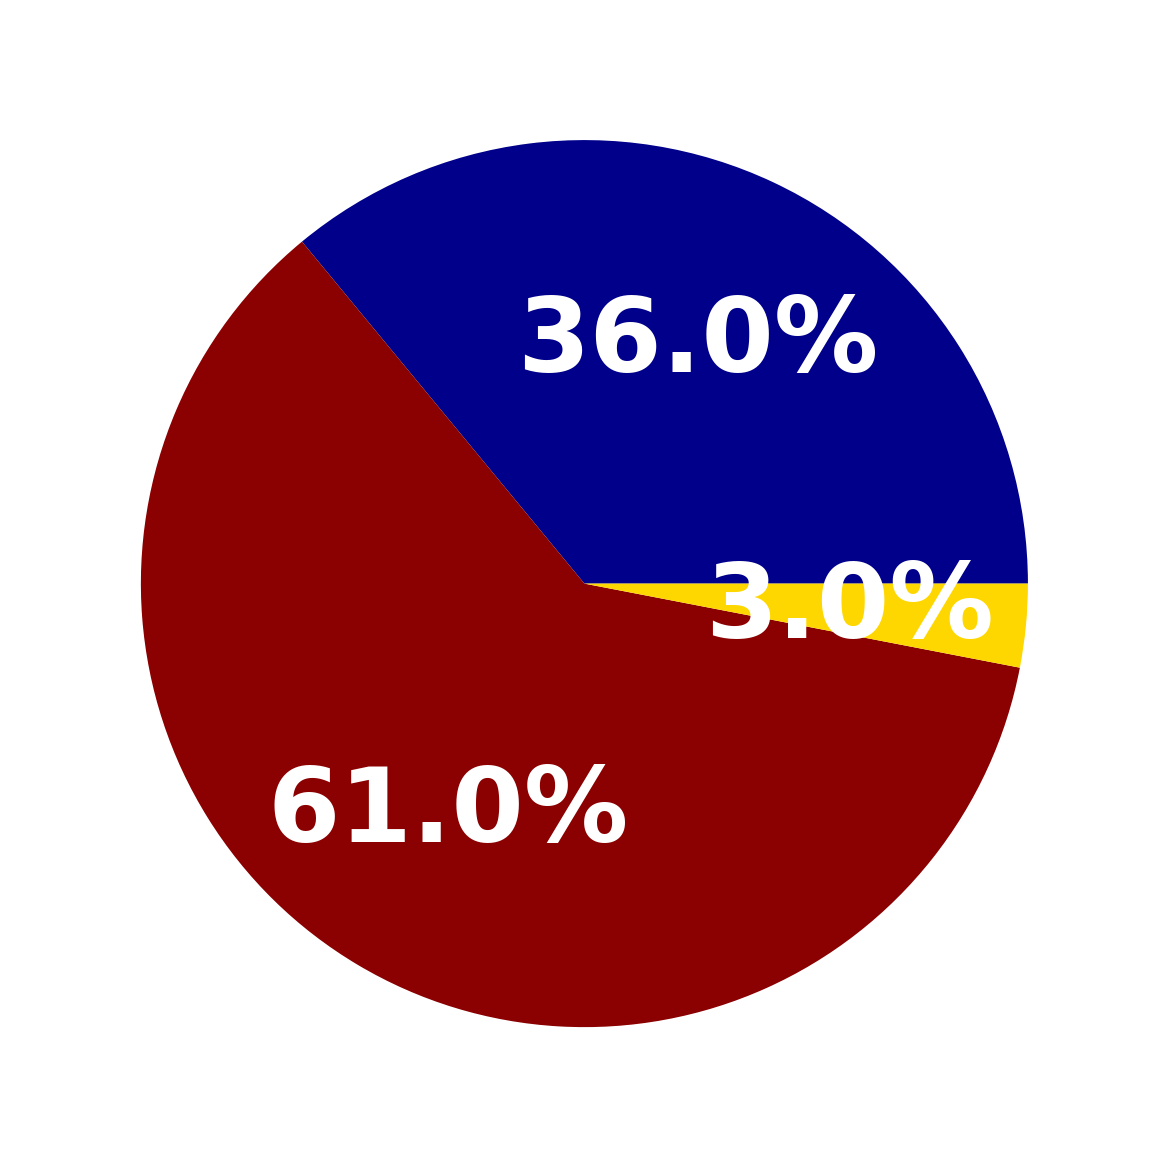

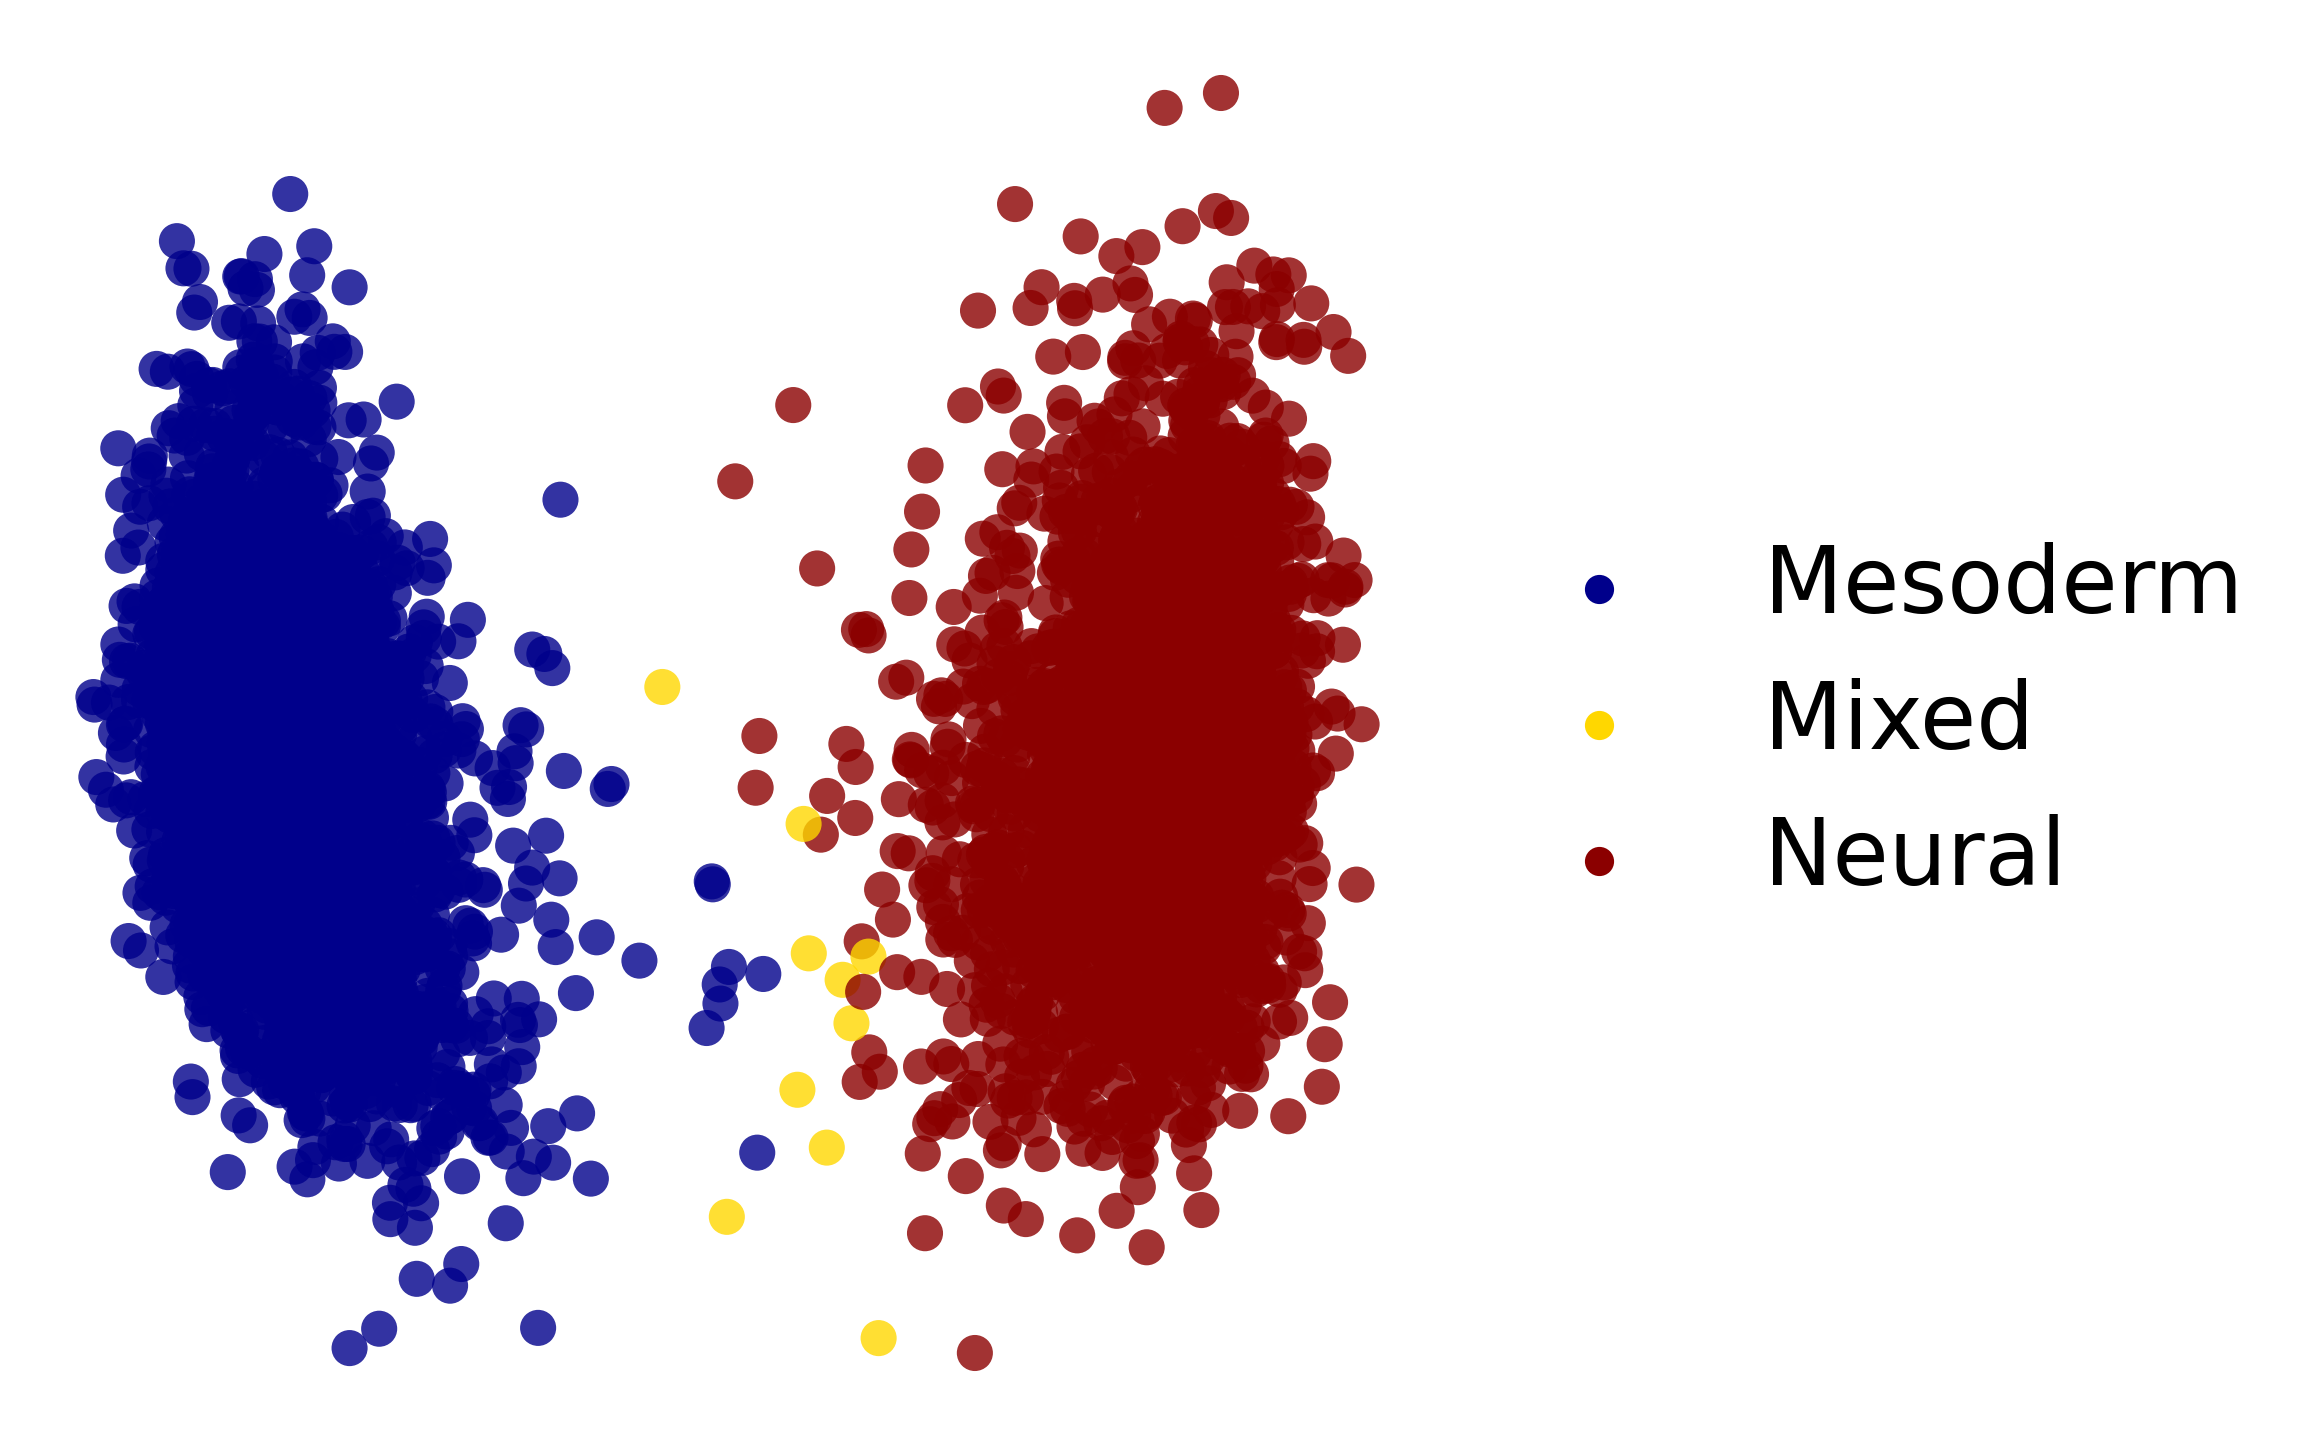

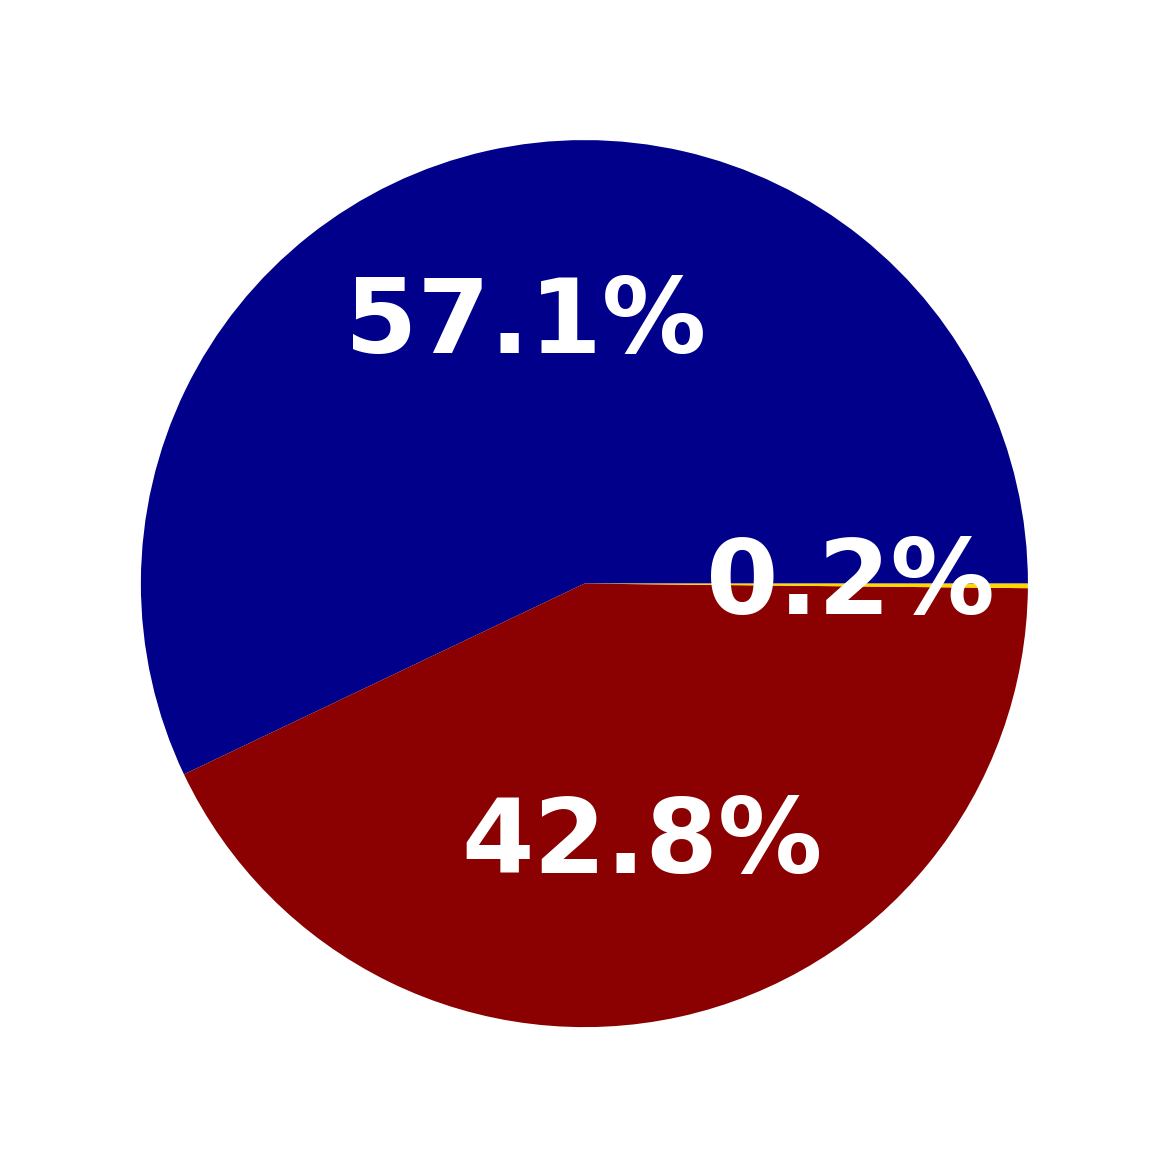

In [25]:
for i, tp in enumerate(['D3.2', 'D3.4', 'D3.6', 'D3.8','D4', 'D5']):
    ic = assigned_cells[tp].copy()
    ic.obsm['X_VIZ'] = PCA().fit_transform(ic.obsm['X_z'])

    pal = {'Mesoderm':'darkblue','Neural':'darkred','Mixed':'gold','off-manifold':'lightgrey'}
    
    leg = 'right' if tp=='D5' else False
    
    fig, ax = plt.subplots(figsize=(6,6), dpi=300)
    scv.pl.scatter(ic, alpha=0.8, ax=ax, size=300, legend_fontsize=22, 
                   title='', fontsize=22, palette=pal, legend_loc=leg,
                   basis='VIZ', color='fate_description', components="1,2", show=False)
    for fig in plt.get_fignums():
        fig = plt.figure(fig)
        # Set the figure facecolor to transparent
        fig.patch.set_facecolor('none')

        # Loop over the axes in the figure
        for ax in fig.get_axes():
            # Set the axes facecolor to white
            ax.set_facecolor('none')
    
    plt.savefig(f'../figures/2.8.{i*2}_fatemap_{tp}.png', bbox_inches='tight', transparent=True)
    
    plot_string_percentages(ic.obs.fate_description.values, palette=pal, 
                            save=f'../figures/2.8.{i*2+1}_piechart_{tp}.png')
    plt.show()


# noise-mix plot

In [25]:
sde_model.adata.obs['tp'] = sde_model.adata.obs.timepoint.map(lambda x: (x.replace('D',''))).astype(float)

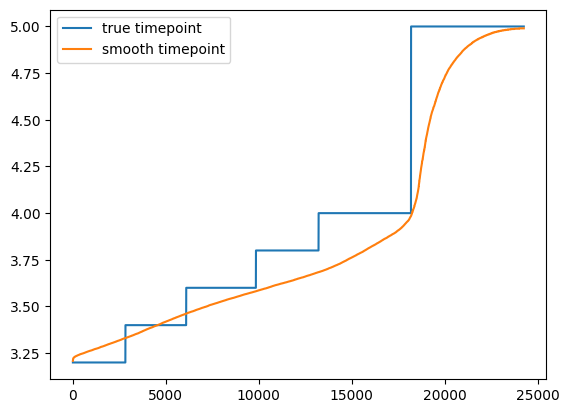

In [26]:
x = sde_model.adata.obs['tp'].values.reshape(-1,1)
nn=500
cnx = vt.pp.connectivities(adata=sde_model.adata, n_neighbors=nn)
xs = vt.pp.moments(x, cnx, n_neighbors=nn)

plt.plot(np.sort(x, axis=0).flatten(), label='true timepoint')
plt.plot(np.sort(xs, axis=0).flatten(), label='smooth timepoint')
plt.legend()
plt.show()

In [27]:
sde_model.adata.obs['smooth_time'] = xs

In [28]:
noises = np.linspace(0.05,0.25,5)

In [29]:
results = []
timesteps = np.linspace(3.2, 5, 7)
timepoints = np.array([round((timesteps[i]+timesteps[i+1])/2,2) for i in range(timesteps.shape[0]-1)])
n_cells = 400
n_repeats = 3

In [30]:
%%time
for noise in noises:
    clear_output(wait=True)
    print("Noise: ", noise)
    mixedness = np.zeros((n_repeats, len(timesteps) - 1))
    for r in range(n_repeats):
        for t in range(len(timesteps) - 1):
            start = timesteps[t]
            end = timesteps[t+1]
            x = sde_model.adata.obs.smooth_time.values
            idx = np.array(x>=start).flatten()&np.array(x<end).flatten()
            initial_cells = sde_model.adata[idx]
            initial_subset = initial_cells[np.random.choice(initial_cells.shape[0], size=n_cells, replace=False)]
            # use same trajectory params as previous notebook
            sde_model.module.sde.noise_scalar = noise
            with torch.no_grad():
                trajectories, cell_ids = sde_model.simulate(
                    initial_cells=initial_subset,
                    n_samples_per_cell=25,
                    n_steps = 100,
                    t_max = 70,
                    dt = 1.0,
                    latent_key='X_z',
                    n_chunks=10
                )
                avg_center, labels, centers, index = vt.cl.cluster_trajectories(trajectories, n_clusters=2)
                cluster_labels = labels.cpu().numpy()
                bifurcation_probability(
                    initial_subset,
                    cell_ids,
                    cluster_labels
                )
                initial_subset.obs['mixed_fate'] = ((initial_subset.obs.fate_prob_0.values>0)&
                                                   (initial_subset.obs.fate_prob_1.values>0))
                mixedness[r, t] = initial_subset.obs.mixed_fate.values.mean()
    results.append(mixedness.mean(0))

Noise:  0.25


Simulating Chunk 9: 100%|██████████| 10/10 [00:00<00:00, 16.84it/s]


CPU times: user 1h 16min 11s, sys: 2min 28s, total: 1h 18min 39s
Wall time: 1h 18min 48s


In [31]:
import matplotlib

cmap = matplotlib.cm.get_cmap('plasma')

colors = cmap(np.linspace(0.1,0.9,6))

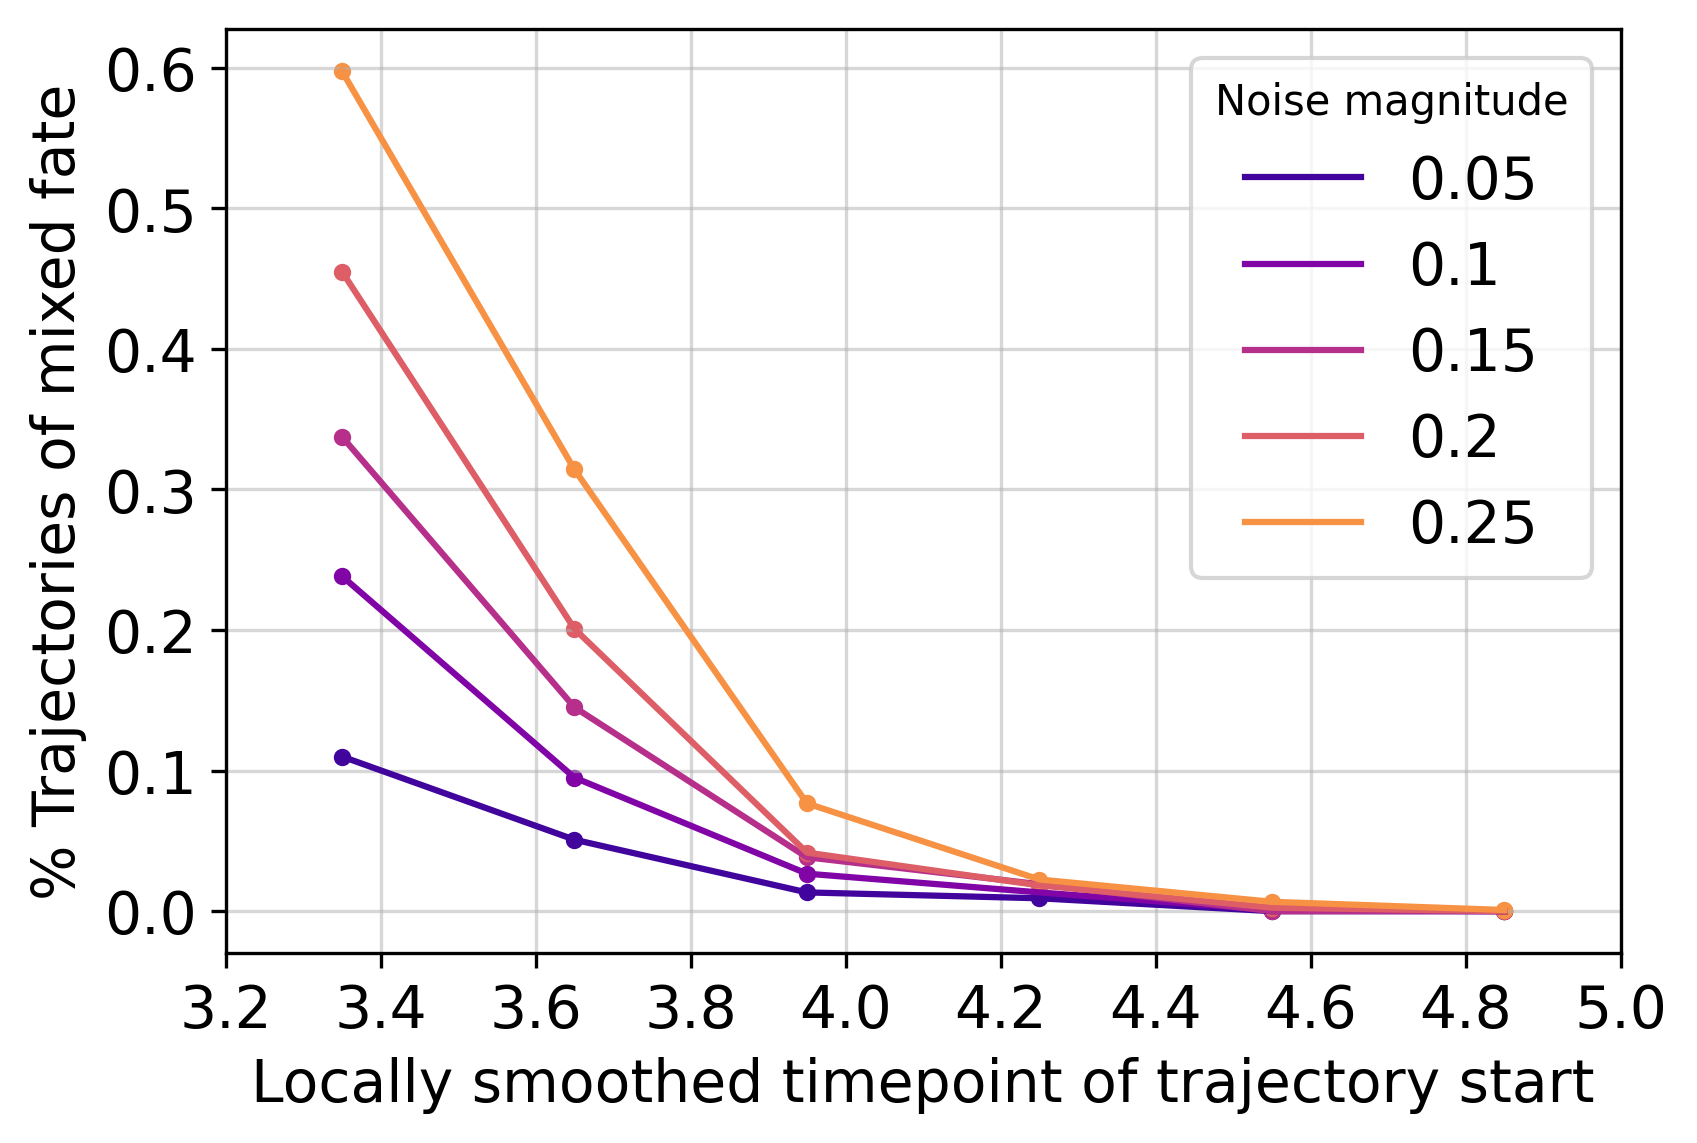

In [32]:
plt.figure(figsize=(6,4), dpi=300)
for res, col, noi in zip(results, colors, noises):
    plt.plot(timepoints, res, color=col, label=round(noi,2))
    plt.scatter(timepoints, res, color=col, s=10)
plt.legend(title='Noise magnitude', fontsize=14)
plt.ylabel("% Trajectories of mixed fate", fontsize=14)
plt.xlabel("Locally smoothed timepoint of trajectory start", fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlim((3.2,5))
plt.grid(alpha=0.5)
for fig in plt.get_fignums():
    fig = plt.figure(fig)
    # Set the figure facecolor to transparent
    fig.patch.set_facecolor('none')

    # Loop over the axes in the figure
    for ax in fig.get_axes():
        # Set the axes facecolor to white
        ax.set_facecolor('white')
plt.savefig('../figures/2.8.13_noise_mixture_plot.png', bbox_inches='tight')
plt.show()